# Bases de datos que usas sin saberlo -- Codecamp'18

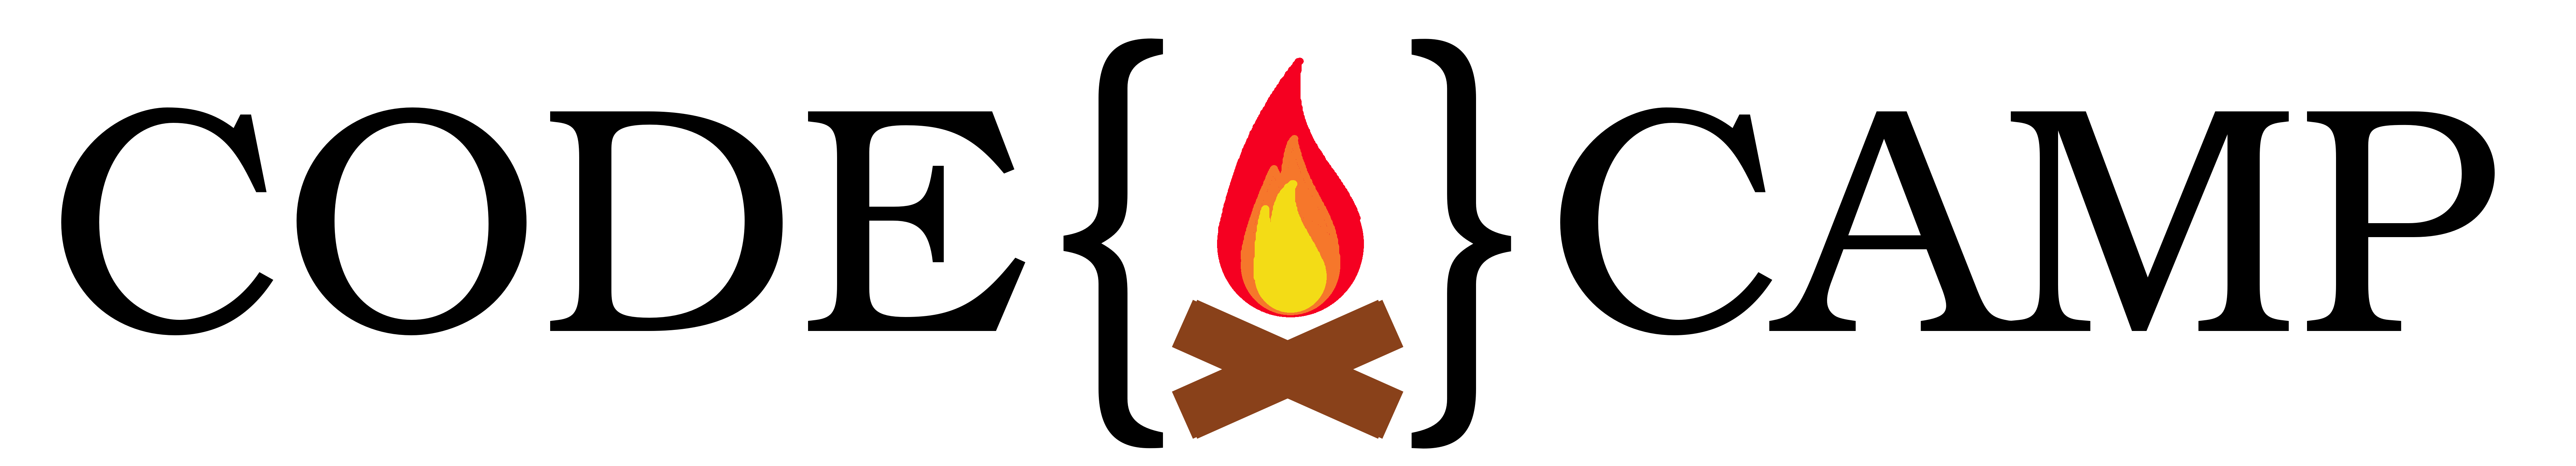

Este tutorial está disponible en https://github.com/dsevilla/codecamp18.
María José Ortín Ibáñez, [mjortin@um.es](mailto:mjortin@um.es) y Diego Sevilla Ruiz, [dsevilla@um.es](mailto:dsevilla@um.es).

In [ ]:
%load utils/functions.py

In [ ]:
from IPython.display import Image
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

In [ ]:
yoda(u"Para alcanzar la fuerza NoSQL debes conocer")

In [ ]:
chew("Grrrrrrr!")

In [ ]:
%%bash
sudo docker pull mongo

In [ ]:
!pip install pymongo
!pip install lxml
!pip install folium
!pip install ipython-cypher

In [ ]:
!sudo docker run --rm -d --name mongo -p 27017:27017 mongo

In [ ]:
import pymongo
from pymongo import MongoClient
client = MongoClient("localhost", 27017)
client

Creamos una base de datos `codecamp18`:

In [ ]:
db = client.codecamp18

Y la colección `participantes18`:

In [ ]:
participantes18 = db.participantes18
participantes18

In [ ]:
participantes18.insert_one(
    {'nombre': 'Diego Sevilla Ruiz',
    'dni' : '12345678X',
    'photo': 'Chewbacca',
    'intereses' : ['charla#2', 'charla#3', 'charla#4', 'charla#5']
    })

In [ ]:
client.database_names()

In [ ]:
DictTable(participantes18.find_one())

In [ ]:
participantes18.insert_one(
    {'nombre': 'María José Ortín Ibáñez',
     'dni' : '23456789Y',
     'intereses' : ['charla#2', 'charla#3', 'charla#4', 'charla#5']
    })

También quieren guardar las diferentes charlas que hay... Para ello, nada mejor que obtener la lista de charlas desde la propia página web... :)

In [ ]:
charlas18 = db.charlas18

In [ ]:
# "extra/CodeCamp2018.html"
charlas = pd.read_html('https://dafi.inf.um.es/CodeCamp/ediciones/2018/',
                       attrs={'class': 'table'})

In [ ]:
charlas = charlas[1]
charlas

In [ ]:
for row in charlas.itertuples():
    charlas18.insert_one({'_id' : "charla%s" % (row[1]),
                          'título' : row[2],
                          'ponentes' : row[3]
                         })

In [ ]:
ListDictTable(list(charlas18.find()))

## Equivalente en SQL
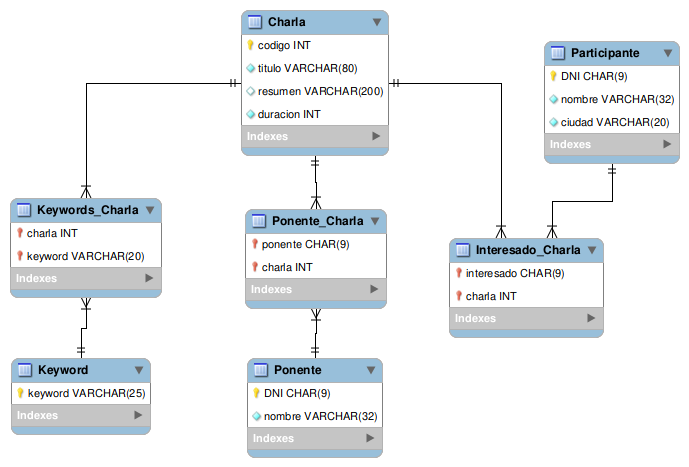

```
CREATE TABLE Participante (
  DNI CHAR(9) NOT NULL,
  nombre VARCHAR(32) NOT NULL,
  ciudad VARCHAR(20) NOT NULL,
  PRIMARY KEY(DNI)
);
CREATE TABLE Charla (
  codigo INT NOT NULL,
  titulo VARCHAR(80) NOT NULL,
  resumen VARCHAR(200) NULL,
  duracion INT DEFAULT 30 NOT NULL,
  PRIMARY KEY (codigo)
);

CREATE TABLE Interesado_Charla (
  interesado CHAR(9) NOT NULL,
  charla INT NOT NULL,
  PRIMARY KEY (interesado, charla),
  FOREIGN KEY (interesado)
    REFERENCES PARTICIPANTE(DNI)
    ON DELETE CASCADE,
  FOREIGN KEY (charla)
    REFERENCES CHARLA(codigo)
    ON DELETE CASCADE
);

CREATE TABLE Ponente (
  DNI CHAR(9) NOT NULL,
  nombre VARCHAR(32) NOT NULL,
  PRIMARY KEY (DNI)
);

CREATE TABLE Keyword(
  keyword VARCHAR(25) PRIMARY KEY
);

CREATE TABLE Ponente_Charla (
  ponente CHAR(9) NOT NULL,
  charla INT NOT NULL,
  PRIMARY KEY (ponente, charla),
  FOREIGN KEY (ponente)
    REFERENCES PONENTE(DNI)
    ON DELETE CASCADE,
  FOREIGN KEY (charla)
    REFERENCES CHARLA(codigo)
    ON DELETE CASCADE
);

CREATE TABLE Keywords_Charla (
  charla INT NOT NULL,
  keyword VARCHAR(20) NOT NULL,
  PRIMARY KEY(charla, keyword),
  FOREIGN KEY (charla)
    REFERENCES CHARLA(codigo)
    ON DELETE CASCADE,
  FOREIGN KEY (keyword)
    REFERENCES KEYWORD(keyword)
);
```

# MongoDB (documentos)

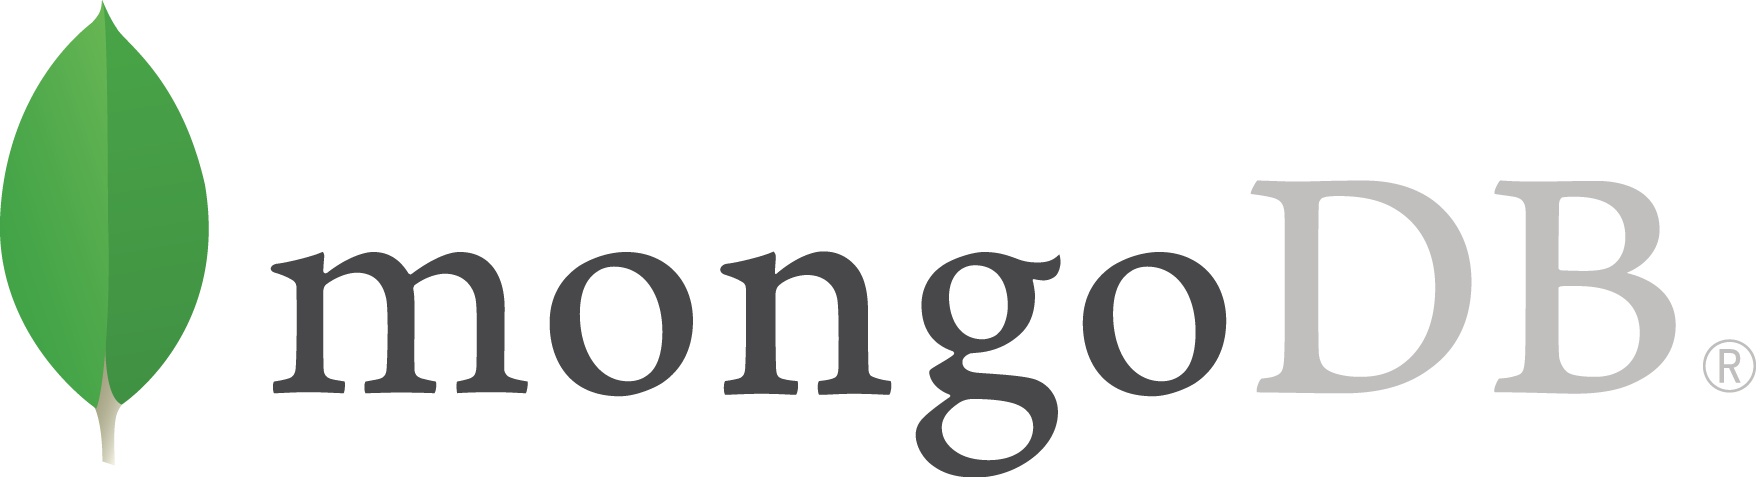

Base de datos documental que usaremos como ejemplo. Una de las más extendidas:

- Modelo de documentos JSON (BSON, en binario, usado para eficiencia)
- Map-Reduce para transformaciones de la base de datos y consultas
- Lenguaje propio de manipulación de la base de datos llamado "de agregación" (aggregate)
- Soporta sharding (distribución de partes de la BD en distintos nodos)
- Soporta replicación (copias sincronizadas master-slave en distintos nodos)
- No soporta ACID
- La transacción se realiza a nivel de **DOCUMENTO**

Usaremos `pymongo` desde Python. Para instalarlo:

    pip install --upgrade pymongo


## Añadiendo a los participantes

Obviamente no tengo la lista de participantes. Generaremos unos cuantos para tener datos como los que se tendrían en el CodeCamp...

In [ ]:
nombres = ['Darth', 'Han', 'Obi-Wan', 'Leia', 'Padmé', 'Yoda', 'Anakin', 'Luke', 'Chewbacca', 'Kylo', 'Jabba']
apellidos = ['Vader', 'Solo', 'Kenobi', 'Organa', 'Amidala', 'Skywalker', 'Ren', 'Maul', 'el Hutt']
nombres_charlas = list(charlas[0].apply(lambda e: "charla%s" % (e)))

import random
import string

def genera_participantes():
    for nombre in nombres:
        for apellido in apellidos:
            nombre_apellido = "%s %s" % (nombre, apellido)          
            participantes18.insert_one(
                {'nombre': nombre_apellido,
                 'dni': ''.join(random.sample(string.digits, 8) +
                                random.sample(string.ascii_uppercase, 1)),
                 'intereses': sorted(random.sample(nombres_charlas,
                                                   random.randint(1,len(nombres_charlas))))
                                 
                })
                
# Llamar a la función
genera_participantes()

In [ ]:
participantes18.find_one({'nombre': 'Luke Skywalker'})

## Shell de Mongo
Para usar el shell de mongo en Javascript:

    docker exec -it mongo mongo

## Ups, olvidé añadir la ciudad de cada persona

In [ ]:
ciudades = ['Mula']

In [ ]:
df = pd.read_csv('extra/municipios-españa-2017.csv.gz',header=0,compression='gzip')

In [ ]:
df.head()

In [ ]:
mula = df[df.NOMBRE_ACTUAL==ciudades[0]].iloc[0]
mula

In [ ]:
import folium

map = folium.Map(location=[38,-1.5],zoom_start=9)
for nombre_ciudad in ciudades:
    ciudaddf = df[df.NOMBRE_ACTUAL == nombre_ciudad]
    if not ciudaddf.empty:
        ciudad = ciudaddf.iloc[0]
        folium.Marker(location=[ciudad.LATITUD_ETRS89,ciudad.LONGITUD_ETRS89],
                      popup=nombre_ciudad).add_to(map)
    else:
        print("No encontrado: %s" % (nombre_ciudad))

map

Añado una ciudad al azar a cada participante:

In [ ]:
for obj in participantes18.find({'ciudad': {'$exists' : False}}):
    participantes18.update_one({'_id': obj['_id']},
                               {'$set' : {'ciudad': random.sample(ciudades,1)[0]}})

In [ ]:
list(participantes18.find())

## Consultas sencillas

Distribución del número de charlas en las que están interesadas los asistentes.

In [ ]:
intereses = participantes18.find(filter={},projection={'intereses': True})

In [ ]:
df = pd.DataFrame([len(s.get('intereses',[])) for s in intereses])
df.astype('int32').plot.hist(bins=[0,1,2,3,4,5,6],figsize=(16,16*3/4))

La función `find()` tiene un gran número de posibilidades para especificar la búsqueda. Se pueden utilizar cualificadores complejos como:

- `$and`
- `$or`
- `$not`

Estos calificadores unen "objetos", no valores. Por otro lado, hay otros calificadores que se refieren a valores:

- `$lt` (menor)
- `$lte` (menor o igual)
- `$gt` (mayor)
- `$gte` (mayor o igual)
- `$regex` (expresión regular)

In [ ]:
participantes18.find_one({'nombre': {'$regex' : '.*? Vader'}})

### Map-Reduce

MongoDB incluye dos APIs para procesar y buscar documentos: el API de Map-Reduce y el API de agregación. Veremos primero el de Map-Reduce. Manual: https://docs.mongodb.com/manual/aggregation/#map-reduce



### Histograma del número de charlas en los que cada persona está interesada

Con Map-Reduce se muestra el número de charlas en las que cada persona está interesada.

In [ ]:
from bson.code import Code
map = Code(
    '''function () {
           if ('intereses' in this)
               emit(this.intereses.length, 1)
           else
               emit(0,1)
       }''')
reduce = Code(
    '''function (key, values) {
            return Array.sum(values);
        }''')
results = participantes18.map_reduce(map, reduce, "myresults")

In [ ]:
results = list(results.find())
results

Como un *plot*:

In [ ]:
df = pd.DataFrame(data = [int(r['value']) for r in results], 
                  index = [int(r['_id']) for r in results], 
                  columns=['interesados por número de cursos'])
df.plot(kind='bar',figsize=(20,20*3/4))

## ¿Cuántos interesados en cada charla?:

En SQL:

```
SELECT C.titulo, COUNT(*) interesados
FROM CHARLA C JOIN INTERESADO_CHARLA I 
     ON C.codigo=I.charla
GROUP BY C.titulo 
ORDER BY COUNT(*) DESC ;
```

¿Cómo se haría en MongoDB?

In [ ]:
from bson.code import Code
map = Code(
    '''function () {
           this.intereses.forEach(function(i) {
               emit(i, 1)
           })
       }''')
reduce = Code(
    '''function (key, values) {
            return Array.sum(values);
        }''')
results = participantes18.map_reduce(map, reduce, "myresults")
results = list(db.myresults.find(sort=[('value',-1)]))
results

## Neo4j (Grafos)

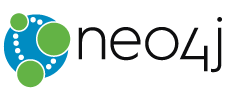

Se puede utilizar el propio interfaz de Neo4j también en la dirección http://127.0.0.1:7474.

In [ ]:
%%bash
sudo docker pull neo4j

In [ ]:
%%bash
sudo docker run -d --rm --name neo4j -p 7474:7474 -p 7687:7687 --env NEO4J_AUTH=none neo4j

Vamos a cargar la extensión `ipython-cypher` para poder lanzar consultas Cypher directamente a través de la hoja. He iniciado la imagen de Neo4j sin autenticación, para pruebas locales.

Utilizaremos una extensión de Jupyter Notebook que se llama `ipython-cypher`. Está instalada en la máquina virtual. Si no, se podría instalar con:

    pip install ipython-cypher
    
Después, todas las celdas que comiencen por `%%cypher` y todas las instrucciones Python que comiencen por `%cypher` se enviarán a Neo4j para su interpretación.

### El lenguaje Cypher


### Ipython-cypher

In [ ]:
%load_ext cypher

In [ ]:
%config CypherMagic.auto_html=False
%config CypherMagic.auto_pandas=True

El lenguaje **Cypher** es el lenguaje de consulta y modificación elegido por Neo4j. Es muy distinto de la mayoría de lenguajes de consulta tradicionales, y casi se podría considerar ASCII-Art...

In [ ]:
PImage.open('images/ch_ascii.png')

Los nodos se identifican con nombres entre paréntesis `(n)`, y las relaciones como flechas simuladas con ASCII:

    (n1)-[:RELACIÓN]->(n2)

In [ ]:
%%cypher
match (n) return n;

Vamos a añadir a los participantes y las charlas. Las conectaremos también por relaciones de interés.

In [ ]:
# Primero las charlas

for charla in charlas18.find():
    nombre_charla = charla['título']
    ponentes = charla['ponentes']
    id = charla['_id']
    %cypher CREATE (n:Charla {id: {id}, título: {nombre_charla}, ponentes: {ponentes}})

In [ ]:
# Ahora los participantes relacionados con las charlas ya creadas

for p in participantes18.find():
    nombre = p['nombre']
    dni = p['dni']
    ciudad = p.get('ciudad','')
    %cypher CREATE (p:Participante {nombre: {nombre}, dni: {dni}, ciudad: {ciudad}})
    for i in p['intereses']:
        %cypher MATCH (c:Charla {id : {i}}), (p:Participante {nombre: {nombre}}) MERGE (p)-[:INTERESADO]->(c)

In [ ]:
#'https://es.wikipedia.org/wiki/Star_Wars'
personajes = pd.read_html("extra/StarWarsWikipedia.html",attrs={'class': 'wikitable'})
personajes = personajes[0]

In [ ]:
personajes.iloc[15:]

In [ ]:
películas = list(personajes.iloc[15])
películas

In [ ]:
for título in películas:
    %cypher CREATE (p:Pelicula {título: {título}})

In [ ]:
import cypher

for p in participantes18.find():
    nombre = p['nombre']
    res = personajes[personajes[0] == nombre]
    if not res.empty:
        for n,app in enumerate(list(res.iloc[0])[1:]):
            if not pd.isnull(app):
                título = películas[n+1]
                print (n,nombre, titulo)
                cypher.run("MATCH (p:Participante {nombre: \"%s\"}), (film:Pelicula {título: \"%s\"}) MERGE (p)-[:STARRING]->(film)"
                           % (nombre, título))

In [ ]:
%config CypherMagic.auto_networkx=False
%config CypherMagic.auto_pandas=False

In [ ]:
%%cypher
MATCH p=shortestPath(
  (hs:Participante {nombre: "Han Solo"})-[*]-(lo:Participante {nombre: "Leia Organa"})
)
RETURN p

In [ ]:
yoda(u'May the force be with you')

In [ ]:
chew('Grrrrrrrrrr!')

In [ ]:
!sudo docker stop neo4j

In [ ]:
!sudo docker stop mongo